In [22]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [2]:
n = 12

centers = [2,4,6,8]
sigma = 0.4
k = len(centers)

#random.seed(2021)
np.random.seed(2021)
#rng = np.random.RandomState(2021)
#rng.random(4)

In [26]:
gt_clusters = np.repeat(np.arange(k), n//k)
gt_clusters

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3])

In [3]:
data = np.concatenate([np.random.normal(loc=m, scale=sigma, size=n//k) for m in centers])
#data

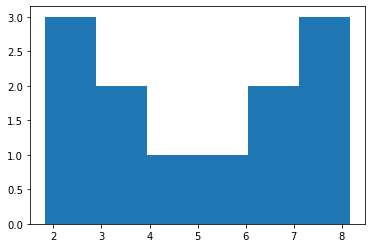

In [4]:
n_bins = n//2
_ = plt.hist(data, bins=n_bins)

In [5]:
def epsilon_neighbor(d, eps=1.0):
    #neighbor_indices, _ = np.where(data < eps**2)
    #return neighbor_indices
    return (d < eps**2).astype(int)

def gauss_sim(d, sigma=1.0):
    #np.log(d)
    return np.exp(-d/sigma**2)

def getSimilarity(data, weighted=True):
    dist = np.square(data - np.tile(data, (data.shape[0],1)).T)
    if weighted:
        return gauss_sim(dist)
    else:
        return epsilon_neighbor(dist)

def getLaplacian(W):
    return np.diag(np.sum(W, axis=0)) - W

In [6]:
W = getSimilarity(data, weighted=False)
W.shape

(12, 12)

In [ ]:
# TODO: Visualize sim graph

In [7]:
W

array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]])

In [8]:
L = getLaplacian(W)
L.shape

(12, 12)

In [9]:
L

array([[ 2, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1,  2, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2, -1, -1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  2, -1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1, -1,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2, -1, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, -1,  2, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, -1, -1,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2, -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  2, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  2]])

In [10]:
lam, U = np.linalg.eig(L)
#assert(np.all(np.argsort(lam) == np.arange(lam.shape[0])))
sorted_ind = np.argsort(lam)

num_ref = k #int(k*1.5)
smallest_ind = sorted_ind[:k+num_ref]
lam[smallest_ind]

array([-1.11022302e-16, -1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        3.00000000e+00,  3.00000000e+00,  3.00000000e+00,  3.00000000e+00])

In [11]:
smallest_ind

array([ 1,  4,  7, 10,  0,  2,  3,  5])

In [12]:
U[:,smallest_ind[:k]]
U_best = U[:,smallest_ind[:k]]

In [13]:
U_best

array([[-0.57735027,  0.        ,  0.        ,  0.        ],
       [-0.57735027,  0.        ,  0.        ,  0.        ],
       [-0.57735027,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.57735027,  0.        ,  0.        ],
       [ 0.        , -0.57735027,  0.        ,  0.        ],
       [ 0.        , -0.57735027,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.57735027,  0.        ],
       [ 0.        ,  0.        , -0.57735027,  0.        ],
       [ 0.        ,  0.        , -0.57735027,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.57735027],
       [ 0.        ,  0.        ,  0.        , -0.57735027],
       [ 0.        ,  0.        ,  0.        , -0.57735027]])

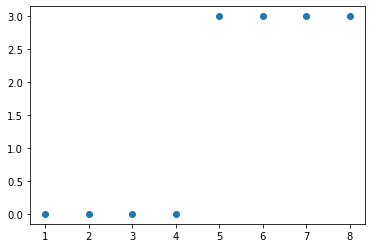

In [14]:
plt.scatter(np.arange(k+num_ref)+1, lam[smallest_ind])

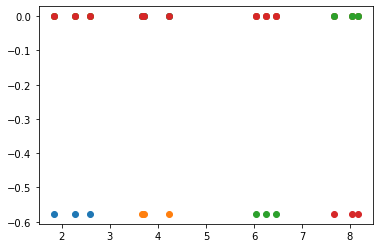

In [17]:
for i in range(k): 
    u = U_best[:,i]
    #print()
    #ax = plt.subplot(k, 1, i+1)
    #all_ax.append(ax)
    #all_ax[i].scatter(data, u)
    plt.scatter(data, u)


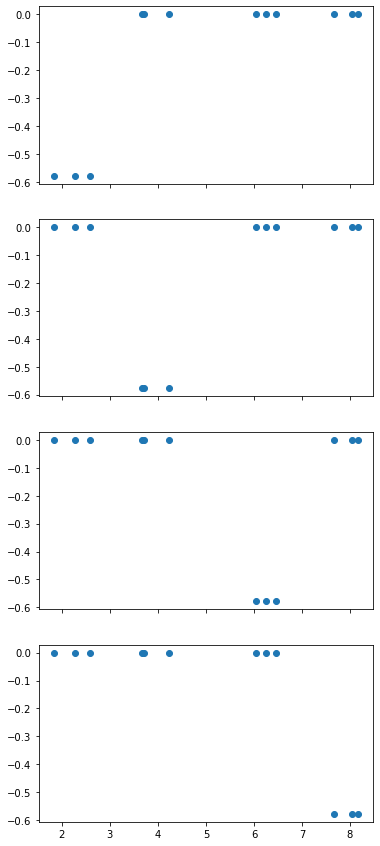

In [16]:
fig, axs = plt.subplots(k, sharex=True, sharey=True)
fig.set_figheight(15)

for i in range(k):
    u = U_best[:,i]
    #print(u)
    axs[i].scatter(data, u)

In [20]:
U_best[0]

array([-0.57735027,  0.        ,  0.        ,  0.        ])

In [23]:
kmeans = KMeans(n_clusters=k).fit(U_best)

In [32]:
def reorderLabels(labels):
    pred = []
    ordered_label = 0
    prev_labels = {}

    for c in labels:
        if c not in prev_labels:
            prev_labels[c] = ordered_label
            ordered_label += 1
        pred.append(prev_labels[c])

    return np.array(pred)

In [34]:
pred_clusters = reorderLabels(kmeans.labels_)
acc = np.sum(pred_clusters == gt_clusters)/n
acc

1.0

In [35]:
def spectral_clustering(data, k):
    W = getSimilarity(data, weighted=False)
    L = getLaplacian(W)
    
    lam, U = np.linalg.eig(L)
    sorted_ind = np.argsort(lam)
    U_best = U[:, sorted_ind[:k]]
    
    kmeans = KMeans(n_clusters=k).fit(U_best)
    pred_clusters = reorderLabels(kmeans.labels_)
    
    return pred_clusters

In [36]:
pred = spectral_clustering(data, k)

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3])

In [45]:
# TODO: change evaluation metric to distance measure
# Compare brute-force search for min distance
def getLoss(data, label, return_cluster_loss=False):
    all_loss = []
    for c in np.unique(label):
        #cluster_indices = np.where(c == pred)
        cluster_data = data[c == label]
        cluster_dist = np.square(cluster_data - np.tile(cluster_data, (cluster_data.shape[0],1)).T)
        cluster_loss = np.sum(cluster_dist)
        all_loss.append(cluster_loss)
    
    return sum(all_loss) if not return_cluster_loss else (sum(all_loss), all_loss)

In [46]:
getLoss(data, pred)

4.201750446428697

In [47]:
getLoss(data, gt_clusters)

4.201750446428697

In [ ]:
# TODO: Control Hyperparameter of getSim

In [ ]:
# TODO: Implement local scaling, add harder example, take time on big example